<a href="https://colab.research.google.com/github/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/2_9_moore_penrose_pseudoinverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##The Moore-Penrose Pseudoinverse

We saw that not all matrices have an inverse. It is unfortunate because the inverse is used to solve system of equations. In some cases, a system of equation has no solution, and thus the inverse doesn't exist. However it can be useful to find a value that is almost a solution (in term of minimizing the error). We will see for instance how we can find the best-fit line of a set of data points with the pseudoinverse.



##Setup

In [1]:
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Plot parameters
sns.set()
%pylab inline
pylab.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['ytick.major.size'] = 0
# Avoid inaccurate floating values (for inverse matrices in dot product for instance)
# See https://stackoverflow.com/questions/24537791/numpy-matrix-inversion-rounding-errors
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


## Intuition

The Moore-Penrose pseudoinverse is a direct application of the SVD (see [2.8](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/)). But before all, we have to remind that systems of equations can be expressed under the matrix form.

As we have seen in [2.3](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.3-Identity-and-Inverse-Matrices/), the inverse of a matrix ${A}$ can be used to solve the equation ${Ax}={b}$:

$$
{A}^{-1}{Ax}={A}^{-1}{b}
$$

$$
{I}_n{x}={A}^{-1}{b}
$$

$$
{x}={A}^{-1}{b}
$$

But in the case where the set of equations have 0 or many solutions the inverse cannot be found and the equation cannot be solved. The pseudoinverse is ${A}^+$ such as:

$$
{A}{A}^+\approx{I_n}
$$

minimizing

$$||{{A}{A}^+-{I_n}}||_2$$

The following formula can be used to find the pseudoinverse:

$$
{A}^+= {VD}^+{U}^T
$$

with ${U}$, ${D}$ and ${V}$ respectively the left singular vectors, the singular values and the right singular vectors of ${A}$ (see the SVD in [2.8](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/)). ${A}^+$ is the pseudoinverse of ${A}$ and ${D}^+$ the pseudoinverse of ${D}$. We saw that ${D}$ is a diagonal matrix and thus ${D}^+$ can be calculated by taking the reciprocal of the non zero values of ${D}$.

This is a bit crude but we will see some examples to clarify all of this.

### Example 1: SVD and its pseudoinverse

Let's see how to implement that. We will create a non square matrix ${A}$, calculate its singular value decomposition and its pseudoinverse.

$$
{A}=\begin{bmatrix}
    7 & 2\\\\
    3 & 4\\\\
    5 & 3
\end{bmatrix}
$$

In [3]:
A = np.array([
  [7, 2],
  [3, 4],
  [5, 3]
])

U, D, V = np.linalg.svd(A)

D_plus = np.zeros((A.shape[0], A.shape[1])).T
D_plus[:D.shape[0], :D.shape[0]] = np.linalg.inv(np.diag(D))

A_plus = V.T.dot(D_plus).dot(U.T)
A_plus

array([[ 0.16666667, -0.10606061,  0.03030303],
       [-0.16666667,  0.28787879,  0.06060606]])

We can now check with the `pinv()` function from Numpy that the pseudoinverse is correct:

In [4]:
np.linalg.pinv(A)

array([[ 0.16666667, -0.10606061,  0.03030303],
       [-0.16666667,  0.28787879,  0.06060606]])

It looks good! We can now check that it is really the near inverse of ${A}$. Since we know that

$${A}^{-1}{A}={I_n}$$

with

$${I_2}=\begin{bmatrix}
    1 & 0 \\\\
    0 & 1
\end{bmatrix}
$$

In [5]:
A_plus.dot(A)

array([[1., 0.],
       [0., 1.]])

This is not bad! This is almost the identity matrix!

A difference with the real inverse is that ${A}^+{A}\approx{I}$ but ${A}{A}^+\neq{I}$.


In [6]:
A.dot(A_plus)

array([[ 0.83333333, -0.16666667,  0.33333333],
       [-0.16666667,  0.83333333,  0.33333333],
       [ 0.33333333,  0.33333333,  0.33333333]])

Another way of computing the pseudoinverse is to use this formula:

$$
({A}^T{A})^{-1}{A}^T
$$

The result is less acurate than the SVD method and Numpy `pinv()` uses the SVD ([cf Numpy doc](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html)). 

Here is an example from the same matrix ${A}$:

In [7]:
A_plus_1 = np.linalg.inv(A.T.dot(A)).dot(A.T)
A_plus_1

array([[ 0.16666667, -0.10606061,  0.03030303],
       [-0.16666667,  0.28787879,  0.06060606]])

In this case the result is the same as with the SVD way.

##Over-determined Linear System

In general there is no solution to overdetermined systems (see [2.4](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.4-Linear-Dependence-and-Span/) ; [Overdetermined systems](https://en.wikipedia.org/wiki/Overdetermined_system)). 

In the following picture, there is no point at the intersection of the three lines corresponding to three equations:

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/overdetermined-system-equations.png?raw=1" width="300" alt="Example of three linear equations in 2 dimensions: this is an overdetermined system" title="Overdetermined system of equations">

<em>There is more equations (3) than unknowns (2) so this is an overdetermined system of equations</em>

The pseudoinverse solve the system in the least square error perspective: it finds the solution that minimize the error. We will see this more explicitly with an example.


>**The pseudoinverse solve the system in the least square error perspective**

###Example 2: Over-determined equation

For this example we will consider this set of three equations with two unknowns:

$$
\begin{cases}
-2x_1 + 2 = x_2 \\\\
4x_1 + 8 = x_2 \\\\
-1x_1 + 2 = x_2
\end{cases}
\Leftrightarrow
\begin{cases}
-2x_1 - x_2 = -2 \\\\
4x_1 - x_2 = -8 \\\\
-1x_1 - x_2 = -2
\end{cases}
$$

Let's see their graphical representation:

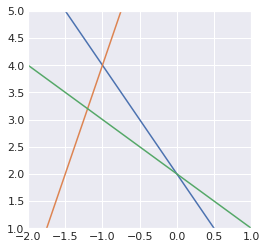

In [8]:
x1 = np.linspace(-5, 5, 1000)

x2_1 = -2 * x1 + 2
x2_2 = 4 * x1 + 8
x2_3 = -1 * x1 + 2

plt.plot(x1, x2_1)
plt.plot(x1, x2_2)
plt.plot(x1, x2_3)

plt.xlim(-2., 1)
plt.ylim(1, 5)
plt.show()

We actually see that there is no solution.

Putting this into the matrix form we have:

$$
{A}=
\begin{bmatrix}
    -2 & -1 \\\\
    4 & -1 \\\\
    -1 & -1
\end{bmatrix}
$$

$$
{x}=
\begin{bmatrix}
    x_1 \\\\
    x_2
\end{bmatrix}
$$

and

$$
{b}=
\begin{bmatrix}
    -2 \\\\
    -8 \\\\
    -2
\end{bmatrix}
$$

So we have:

$$
{Ax} = {b}
\Leftrightarrow
\begin{bmatrix}
    -2 & -1 \\\\
    4 & -1 \\\\
    -1 & -1
\end{bmatrix}
\begin{bmatrix}
    x_1 \\\\
    x_2
\end{bmatrix}
=
\begin{bmatrix}
    -2 \\\\
    -8 \\\\
    -2
\end{bmatrix}
$$

We will now calculate the pseudoinverse of ${A}$:

In [10]:
A = np.array([
  [-2, -1],
  [4, -1],
  [-1, -1]
])

A_plus = np.linalg.pinv(A)
A_plus

array([[-0.11290323,  0.17741935, -0.06451613],
       [-0.37096774, -0.27419355, -0.35483871]])

Now that we have calculated the pseudoinverse of ${A}$:

$$
{A}^+=
\begin{bmatrix}
    -0.11290323 &  0.17741935 & -0.06451613 \\\\
    -0.37096774 & -0.27419355 & -0.35483871
\end{bmatrix}
$$

we can use it to find ${x}$ knowing that:

$$
{x}={A}^+{b}
$$

with:

$$
{x}
=
\begin{bmatrix}
    x1 \\\\
    x2
\end{bmatrix}
$$

In [12]:
b = np.array([
  [-2],
  [-8],
  [-2]
])

result = A_plus.dot(b)
result

array([[-1.06451613],
       [ 3.64516129]])

So we have

$$
\begin{align*}
{A}^+{b}&=
\begin{bmatrix}
    -0.11290323 &  0.17741935 & -0.06451613 \\\\
    -0.37096774 & -0.27419355 & -0.35483871
\end{bmatrix}
\begin{bmatrix}
    -2 \\\\
    -8 \\\\
    -2
\end{bmatrix}\\\\
&=
\begin{bmatrix}
    -1.06451613 \\\\
    3.64516129
\end{bmatrix}
\end{align*}
$$

In our two dimensions, the coordinates of ${x}$ are

$$
\begin{bmatrix}
    -1.06451613 \\\\
    3.64516129
\end{bmatrix}
$$

Let's plot this point along with the equations lines:

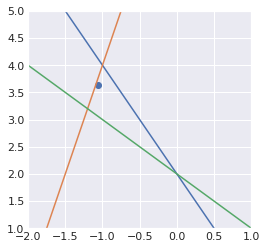

In [13]:
plt.plot(x1, x2_1)
plt.plot(x1, x2_2)
plt.plot(x1, x2_3)

plt.xlim(-2., 1)
plt.ylim(1, 5)

plt.scatter(result[0], result[1])

plt.show()

Maybe you would have expected the point being at the barycenter of the triangle (cf. [Least square solution in the triangle center](https://math.stackexchange.com/questions/471812/is-the-least-squares-solution-to-an-overdetermined-system-a-triangle-center)). 

This is not the case becase the equations are not scaled the same way. Actually the point is at the intersection of the three [symmedians](https://en.wikipedia.org/wiki/Symmedian) of the triangle.

### Example 3: Fit a line

This method can also be used to fit a line to a set of points. 

Let's take the following data points:

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/dataset-representation.png?raw=1" width="300" alt="Representation of a set of data points" title="Some data points">

<em>We want to fit a line to this set of data points</em>

We have this set of ${x}$ and ${y}$ and we are looking for the line $y=mx+b$ that minimizes the error. The error can be evaluated as the sum of the differences between the fit and the actual data points. We can represent the data points with a matrix equations:

$$
{Ax} = {b}
\Leftrightarrow
\begin{bmatrix}
    0 & 1 \\\\
    1 & 1 \\\\
    2 & 1 \\\\
    3 & 1 \\\\
    3 & 1 \\\\
    4 & 1
\end{bmatrix}
\begin{bmatrix}
    m \\\\
    b
\end{bmatrix}
=
\begin{bmatrix}
    2 \\\\
    4 \\\\
    0 \\\\
    2 \\\\
    5 \\\\
    3
\end{bmatrix}
$$

Note that here the matrix ${A}$ represents the values of the coefficients. The column of 1 correspond to the intercepts (without it the fit would have the constraint to cross the origin). It gives the following set of equations:

$$
\begin{cases}
    0m + 1b = 2 \\\\
    1m + 1b = 4 \\\\
    2m + 1b = 0 \\\\
    3m + 1b = 2 \\\\
    3m + 1b = 5 \\\\
    4m + 1b = 3
\end{cases}
$$

We have the set of equations $mx+b=y$. The ones are used to give back the intercept parameter. For instance, in the first equation corresponding to the first point we have well $x=0$ and $y=2$. This can be confusing because here the vector ${x}$ corresponds to the coefficients. This is because the problem is different from the other examples: we are looking for the coefficients of a line and not for $x$ and $y$ unknowns. We kept this notation to indicate the similarity with the last examples.

So we will construct these matrices and try to use the pseudoinverse to find the equation of the line minimizing the error (difference between the line and the actual data points).

Let's start with the creation of the matrix of ${A}$ and ${b}$:

array([[-0.69366543,  0.59343205, -0.40824829],
       [-0.4427092 , -0.79833696, -0.40824829],
       [-0.56818732, -0.10245245,  0.81649658]])

##Conclusion

You can see that the pseudoinverse can be very useful for this kind of problems! The series is not completely finished since we still have 3 chapters to cover. 

However, we have done the hardest part! We will now see two very light chapters before going to a nice example using all the linear algebra we have learn: the PCA.

## References

**Intuition**

- [Sean Owen - Pseudoinverse intuition](https://www.quora.com/What-is-the-intuition-behind-pseudo-inverse-of-a-matrix)

**Numpy**

- [Numpy - linalg.pinv](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html)

- [Numpy random seed](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html)

**Systems of equations**

- [Using the Moore-Penrose Pseudoinverse to Solve Linear Equations](https://www.youtube.com/watch?v=5bxsxM2UTb4)

- [Overdetermined systems](https://en.wikipedia.org/wiki/Overdetermined_system)

- [Least square solution in the triangle center](https://math.stackexchange.com/questions/471812/is-the-least-squares-solution-to-an-overdetermined-system-a-triangle-center)

- [Symmedian](https://en.wikipedia.org/wiki/Symmedian)

**Least square fit**

- [Least square fitting](https://mec560sbu.github.io/2016/08/29/Least_SQ_Fitting/)